**Import Module**

In [1]:
# mount google harddrive
from google.colab import drive
drive.mount('/content/drive')
# import module
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
# set seed
torch.manual_seed(0)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# install shap
# !pip install shap
import shap
# check pytorch version
print("PyTorch version:", torch.__version__)
# use cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PyTorch version: 1.10.0+cu111
device: cuda


**Transform Data and Create Dataloader**

In [2]:
# set batch size
TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 64
# set transformation for training and validation
transform_train = transforms.Compose([
                transforms.Resize(size = (224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5946, 0.5732, 0.5126), std=(0.2671, 0.2737, 0.3058)) # use calculated mean and std
                ])
TRAIN_DATA_ROOT = "/content/drive/MyDrive/BIOSTATS 823/insects/train"
train_dataset = datasets.ImageFolder(TRAIN_DATA_ROOT, transform=transform_train)

VAL_DATA_ROOT = "/content/drive/MyDrive/BIOSTATS 823/insects/test"
val_dataset = datasets.ImageFolder(VAL_DATA_ROOT, transform=transform_train)
# define data loader
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=TRAIN_BATCH_SIZE,
                                           shuffle=True,
                                           num_workers=4)
test_loader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=VAL_BATCH_SIZE,
                                          shuffle=False,
                                          num_workers=4)

# set transformation for SHAP visualization
base_transform = transforms.Compose([
                 transforms.Resize(size = (224, 224)),
                 transforms.ToTensor()                    
                 ]) 
# set dataset
base_dataset = datasets.ImageFolder(TRAIN_DATA_ROOT, transform=base_transform)
# define data loader
base_loader = torch.utils.data.DataLoader(base_dataset,
                                          batch_size=64,
                                          shuffle=True,
                                          num_workers=4)

In [3]:
# check available classes
base_dataset.class_to_idx

{'beetles': 0, 'cockroach': 1, 'dragonflies': 2}

**Get data mean and standard deviation for image normalization**

In [10]:
# calculate mean and std for each channel 
R = 0
G = 0
B = 0
R_2 = 0
G_2 = 0
B_2 = 0

for i in range(1019):
  R += torch.sum(train_dataset[i][0][0])
  G += torch.sum(train_dataset[i][0][1])
  B += torch.sum(train_dataset[i][0][2])
  R_2 += torch.sum(torch.square(train_dataset[i][0][0]))
  G_2 += torch.sum(torch.square(train_dataset[i][0][1]))
  B_2 += torch.sum(torch.square(train_dataset[i][0][2]))

R_mean = R/(224*224)/1019
G_mean = G/(224*224)/1019
B_mean = B/(224*224)/1019

R_2_mean = R_2/(224*224)/1019
G_2_mean = G_2/(224*224)/1019
B_2_mean = B_2/(224*224)/1019

R_std = np.sqrt(R_2_mean - np.square(R_mean))
G_std = np.sqrt(G_2_mean - np.square(G_mean))
B_std = np.sqrt(B_2_mean - np.square(B_mean))

print(R_mean, G_mean, B_mean)
print(R_std, G_std, B_std)

tensor(0.5946) tensor(0.5732) tensor(0.5126)
tensor(0.2671) tensor(0.2737) tensor(0.3058)


**Visualize Data**

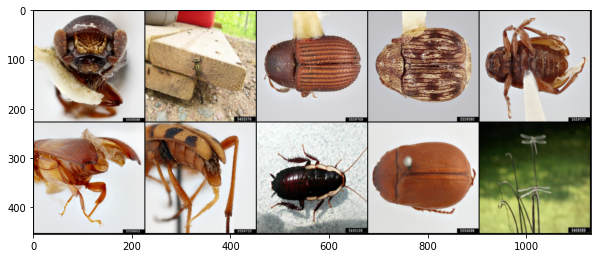

In [4]:
# visualize iamge
images, targets = next(iter(base_loader))
images = images[:10]
targets = targets[:10]
# Plot grid of images
grid_img = torchvision.utils.make_grid(images, 5)

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize = (10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

**Create a Simple CNN**

In [5]:
# define a neural network
class Simple_NN(nn.Module):
    def __init__(self):
        super(Simple_NN, self).__init__()        
        self.conv_sec = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=5),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.fc_sec = nn.Sequential(
            nn.Linear(16*54*54, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 3)
        )

    def forward(self, x):
        conv_out = self.conv_sec(x)
        flatten_out = conv_out.view(-1, 16*54*54)
        fc_out = self.fc_sec(flatten_out)

        return fc_out
# instantiate the network and add to device
model = Simple_NN().to(device)

**Train on Training Data and Validate on Validation Data**

In [6]:
# create loss function
criterion = nn.CrossEntropyLoss().to(device)
# Add optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-3)
# total number of training epochs
EPOCHS = 15
# define lists for tracking performance
train_acc = []
val_acc = []
train_loss_list = []
val_loss_list = []

print("==> Training starts!")
print("="*50)

for i in range(0, EPOCHS):   
    # switch to train mode
    model.train()
    print("Epoch %d:" %i)   
    total_examples = 0
    correct_examples = 0
    train_loss = 0 # track training loss if you want
    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        # compute the output and loss
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        # zero the gradient
        optimizer.zero_grad()
        # backpropagation
        loss.backward()
        # apply gradient and update the weights
        optimizer.step()
        # count the number of correctly predicted samples in the current batch
        _, predicted = torch.max(outputs, 1)
        correct = predicted.eq(targets).sum()
        
        total_examples += targets.shape[0]
        train_loss += loss
        correct_examples += correct.item()
                
    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    train_loss_list.append(float(avg_loss.detach().cpu().numpy()))
    train_acc.append(avg_acc)
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    # switch to eval mode
    model.eval()
    total_examples = 0
    correct_examples = 0 
    val_loss = 0 # again, track the validation loss if you want
    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)
            # compute the output and loss
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            # count the number of correctly predicted samples in the current batch
            _, predicted = torch.max(outputs, 1)
            correct = predicted.eq(targets).sum()
            
            total_examples += targets.shape[0]
            val_loss += loss
            correct_examples += correct.item()

    avg_loss = val_loss / len(test_loader)
    avg_acc = correct_examples / total_examples
    val_loss_list.append(float(avg_loss.detach().cpu().numpy()))
    val_acc.append(avg_acc)
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

==> Training starts!
Epoch 0:
Training loss: 0.7268, Training accuracy: 0.6850
Validation loss: 0.7764, Validation accuracy: 0.5889
Epoch 1:
Training loss: 0.4608, Training accuracy: 0.8322
Validation loss: 0.5880, Validation accuracy: 0.7722
Epoch 2:
Training loss: 0.3110, Training accuracy: 0.8960
Validation loss: 0.3667, Validation accuracy: 0.8667
Epoch 3:
Training loss: 0.2688, Training accuracy: 0.8999
Validation loss: 0.3658, Validation accuracy: 0.8667
Epoch 4:
Training loss: 0.2249, Training accuracy: 0.9215
Validation loss: 0.2817, Validation accuracy: 0.8722
Epoch 5:
Training loss: 0.1279, Training accuracy: 0.9529
Validation loss: 0.1398, Validation accuracy: 0.9500
Epoch 6:
Training loss: 0.0720, Training accuracy: 0.9774
Validation loss: 0.1193, Validation accuracy: 0.9611
Epoch 7:
Training loss: 0.0832, Training accuracy: 0.9676
Validation loss: 0.0643, Validation accuracy: 0.9722
Epoch 8:
Training loss: 0.0416, Training accuracy: 0.9863
Validation loss: 0.0334, Validati

**Visualize Performance**

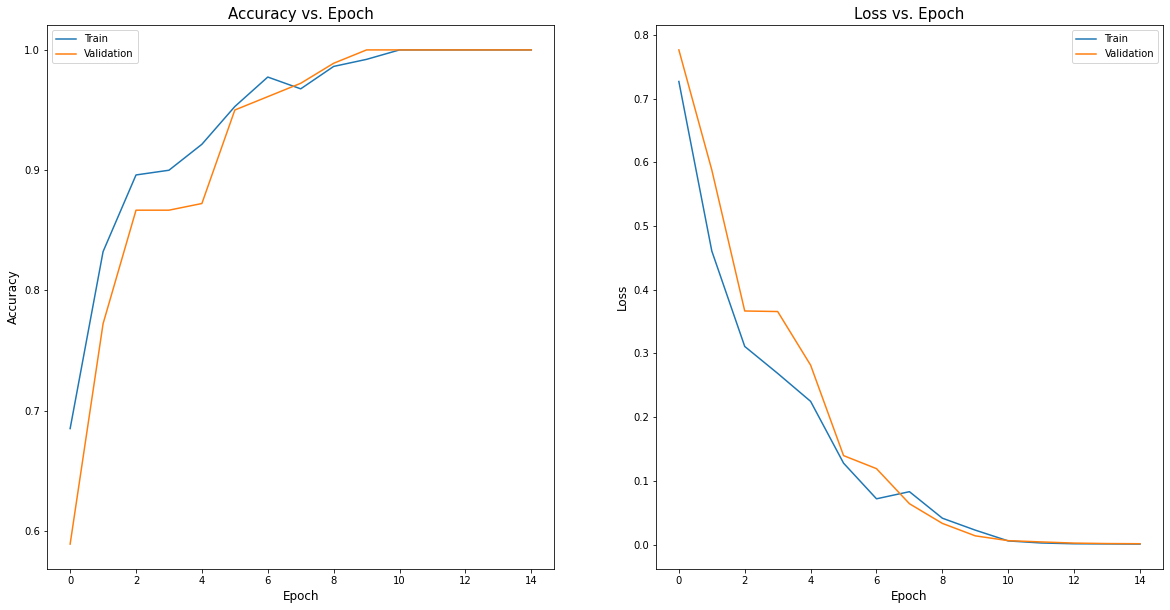

In [7]:
# plot accraucy and loss for both train and validation data
plt.figure(figsize = (20, 10))
plt.subplot(1, 2, 1)
sns.lineplot(x = np.arange(15), y = train_acc, label = 'Train')
sns.lineplot(x = np.arange(15), y = val_acc, label = 'Validation')
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Accuracy', fontsize = 12)
plt.title('Accuracy vs. Epoch', fontsize = 15)
plt.subplot(1, 2, 2)
sns.lineplot(x = np.arange(15), y = train_loss_list, label = 'Train')
sns.lineplot(x = np.arange(15), y = val_loss_list, label = 'Validation')
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Loss', fontsize = 12)
plt.title('Loss vs. Epoch', fontsize = 15)
plt.show()

**Use SHAP (SHapley Additive ExPlanations)**

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


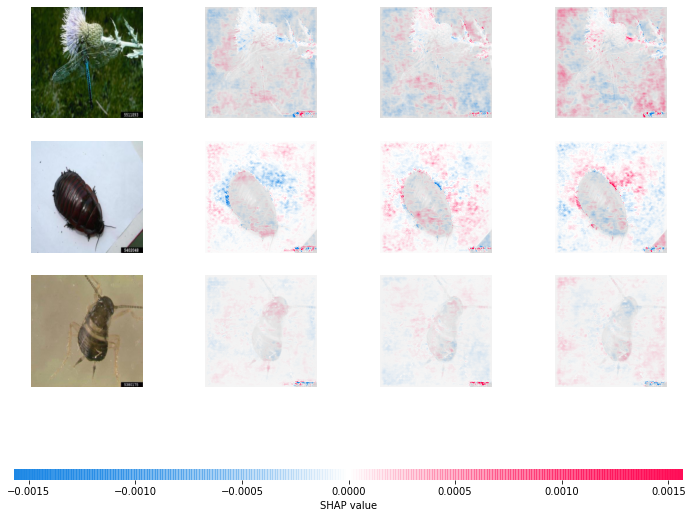

In [8]:
batch = next(iter(base_loader))
images, labels = batch

background = images[:61].to(device)
test_images = images[61:64].to(device)

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.detach().cpu().numpy(), 1, -1), 1, 2)

# plot the feature attributions
shap.image_plot(shap_numpy, test_numpy)